В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [3]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [4]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [668]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes=(100,), epsilon=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, hidden_layers):
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(1)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) * 0.01)
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
       
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
        
        for i in range(0, self.n_layers):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
                       
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        
        for i in range(self.n_layers-1, 0, -1):
            dA[i-1] = np.dot(W[i].T, dZ[i])
            dZ[i-1] = np.multiply(dA[i-1], np.multiply(A[i-1], 1 - A[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)        
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes)

        for i in range(self.max_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
                
            if i > 1 and abs(cost-cost_history[-2]) < self.epsilon:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [192]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, y.shape))

In [542]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, y.shape))

Training set: X=(118, 2), y=(118,)


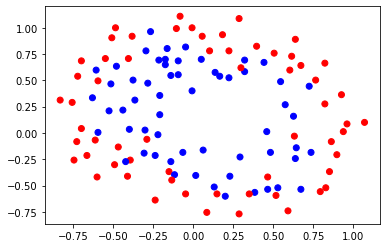

In [543]:
plot_data(X, Y)

In [687]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(94, 2), y=(94,)
Test set: X=(24, 2), y=(24,)


In [722]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, max_iter = 4000, hidden_layer_sizes=(10,), epsilon=1e-8)

In [723]:
cls.n_layers

2

0-th iteration: 0.6931866357508909
1000-th iteration: 0.6845461717597779
2000-th iteration: 0.5068717789120855
3000-th iteration: 0.38658192236718564


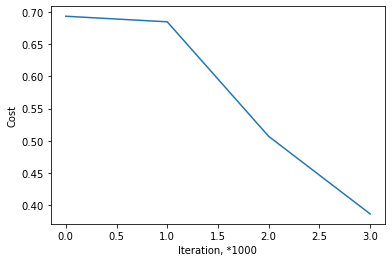

In [724]:
cls.fit(X_train, y_train.values.reshape((X_train.shape[0], 1)))

In [725]:
cls.n_iter

3999

In [726]:
print(cls.parameters)

{'W': [array([[-1.04443091,  0.54796563],
       [ 3.01536112,  0.67614063],
       [ 0.43434565, -2.57300599],
       [ 0.35347792, -1.35683486],
       [ 0.60491502, -0.51530254],
       [-0.2551071 ,  1.3472994 ],
       [-1.64445433,  0.18657228],
       [ 0.14412979,  2.45954438],
       [ 2.38425225,  1.92301231],
       [ 0.59767694, -0.42894023]]), array([[-2.58580779,  4.66653897, -2.55229288, -1.78290435, -1.23002266,
         7.1737124 , -5.38815643, -5.5995091 , -7.74204601, -1.1128476 ]])], 'b': [array([[-1.94614108],
       [ 3.32599852],
       [-1.1533854 ],
       [-1.05402241],
       [-0.77976313],
       [ 3.74469623],
       [-4.16173046],
       [-4.09578309],
       [-3.80335001],
       [-0.68087871]]), array([[-1.06174983]])]}


In [727]:
Y_prob = cls.predict_proba(X_test)
print(Y_prob)

[[0.02798522 0.97201478]
 [0.03701646 0.96298354]
 [0.10133187 0.89866813]
 [0.94393467 0.05606533]
 [0.23842732 0.76157268]
 [0.246133   0.753867  ]
 [0.33656875 0.66343125]
 [0.98535251 0.01464749]
 [0.19129048 0.80870952]
 [0.79212089 0.20787911]
 [0.77526555 0.22473445]
 [0.73382558 0.26617442]
 [0.30462194 0.69537806]
 [0.98201475 0.01798525]
 [0.01924891 0.98075109]
 [0.44011778 0.55988222]
 [0.46033347 0.53966653]
 [0.45963403 0.54036597]
 [0.14028359 0.85971641]
 [0.98738341 0.01261659]
 [0.95605971 0.04394029]
 [0.05238162 0.94761838]
 [0.08359566 0.91640434]
 [0.02931401 0.97068599]]


In [728]:
Y_hat = cls.predict(X_test)
Y_hat

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

In [729]:
accuracy_score(y_test, Y_hat)

0.8333333333333334

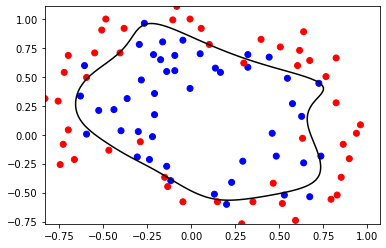

In [730]:
plot_data(X_train, y_train)
plot_surface(cls, X[:, 0], X[:, 1])

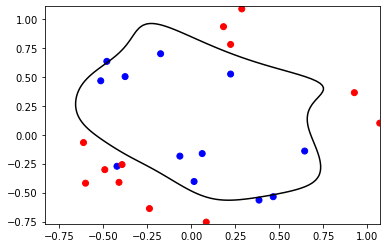

In [731]:
plot_data(X_test, y_test)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [621]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant', random_state=0)

In [622]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

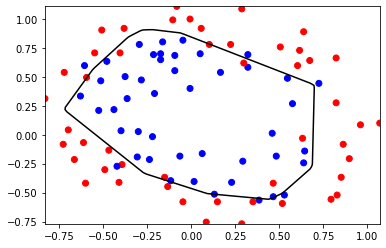

In [623]:
plot_data(X_train, y_train)
plot_surface(clf, X[:, 0], X[:, 1])

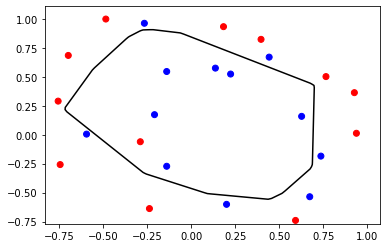

In [624]:
plot_data(X_test, y_test)
plot_surface(clf, X[:, 0], X[:, 1])

In [625]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576

In [626]:
clf.n_iter_

1681